# Dynamic mode decomposition with control on a high-dimensional, stable, linear system
Dynamic mode decomposition with control (DMDc) aims to disambiguate the effect of control/actuation
from the unforced dynamics.
We apply DMDc to a high-dimensional, stable, linear system
with intrinsic low-dimensional dynamics
(this is example 2 in Sec. 4 in Proctor et al., _"Dynamic Mode Decomposition with Control"_, SIAM 2016).

$$x_{k+1} =Ax_k + B u_k,\quad y_k = Cx_k$$

We first import the pyKoopman package and other packages for plotting and matrix manipulation.

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.cm as cm

import pykoopman as pk

Define state and control matrices of the linear control system and collect data.

In [45]:
from pykoopman.common  import drss, advance_linear_system

n_states = 5
n_controls = 2
n_measurements = 5
A,B,C = drss(n_states, n_controls, n_measurements)

x0 = np.array([4,7,2,8,0])
u = np.array([[-4, -2, -1, -0.5, 0, 0.5, 1, 3, 5, 9,
               8, 4, 3.5, 1, 2, 3, 1.5, 0.5, 0, 1,
               -1, -0.5, -2, -4, -5, -7, -9, -6, -5, -5.5],
              [4, 1, -1, -0.5, 0, 1, 2, 4, 3, 1.5,
               1, 0, -1, -1.5, -2, -1, -3, -5, -9, -7,
               -5, -6, -8, -6, -4, -3, -2, -0.5, 0.5, 3]])
n = u.shape[1]
X,Y = advance_linear_system(x0,u,n,A,B,C)
U = u.transpose()

Visualization of the system and collected data.

[Text(0.5, 1.0, 'C')]

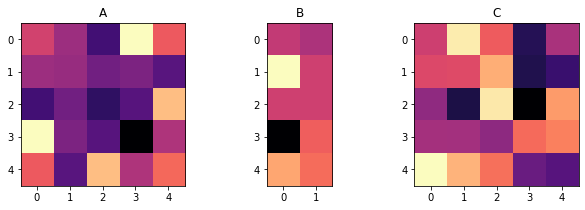

In [46]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(131)
ax.imshow(A, aspect='auto', cmap=plt.get_cmap('magma'))
ax.set(title='A')

ax = fig.add_subplot(132)
ax.imshow(B, aspect='1', cmap=plt.get_cmap('magma'))
ax.set(title='B')

ax = fig.add_subplot(133)
ax.imshow(C, aspect='auto', cmap=plt.get_cmap('magma'))
ax.set(title='C')


[Text(0, 0.5, '$Y$'), Text(0.5, 0, 'steps $k$')]

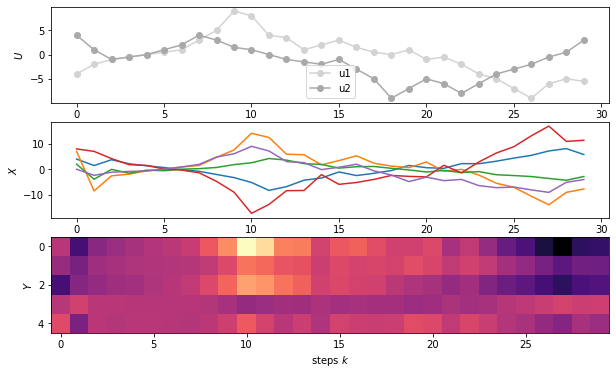

In [47]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(311)
ax.plot(np.linspace(0,n-1,n),U[:,0],'-o', color='lightgrey', label='u1')
ax.plot(np.linspace(0,n-1,n),U[:,1],'-o', color='darkgrey', label='u2')
ax.set(ylabel=r'$U$')
ax.legend()

ax = fig.add_subplot(312)
ax.plot(np.linspace(0,n-1,n),X,'-', label='X')
ax.set(ylabel=r'$X$')

ax = fig.add_subplot(313)
ax.imshow(Y.transpose(), aspect='auto', cmap=plt.get_cmap('magma'))
# ax.set_aspect('auto')
ax.set(
        ylabel=r'$Y$',
        xlabel=r'steps $k$')

Apply DMD with control to the measurement data $Y$ collected from the controlled system.

False

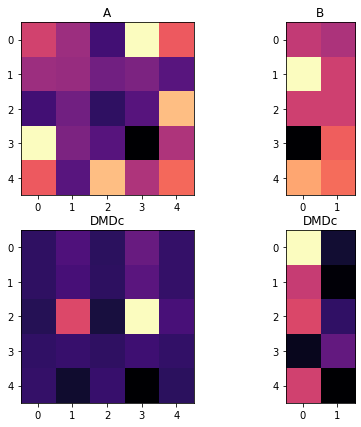

In [48]:
DMDc = pk.regression.DMDc(svd_rank=7, svd_output_rank = 5)

model = pk.Koopman(regressor=DMDc)
model.fit(Y,U)
Aest = model.state_transition_matrix
Best = model.control_matrix

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(221)
ax.imshow(A, aspect='equal', cmap=plt.get_cmap('magma'))
ax.set(title='A')

ax = fig.add_subplot(222)
ax.imshow(B, aspect='equal', cmap=plt.get_cmap('magma'))
ax.set(title='B')

ax = fig.add_subplot(223)
ax.imshow(Aest, aspect='equal', cmap=plt.get_cmap('magma'))
ax.set(title='DMDc')

ax = fig.add_subplot(224)
ax.imshow(Best, aspect='equal', cmap=plt.get_cmap('magma'))
ax.set(title='DMDc')

# Only true if C = Inxn, where n = number of states x
np.allclose(np.concatenate((A,B),axis=1),np.concatenate((Aest,Best),axis=1))

Note that the resulting system matrices, $A^{DMDc}$ and $B^{DMDc}$, may not be identical to the original
system matrices, $A$ and $B$, as DMDc is applied to
the measurement data $Y$, and not the state $X$.
Further, if the number of measurements is larger than the state dimension,
a low-dimensional projection is performed.
However, the systems are identical up to a linear transformation,
so the eigenvalues must be the same. Let's check that.

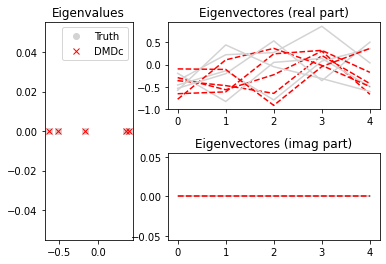

In [49]:
W,V = np.linalg.eig(A)

West, Vest = np.linalg.eig(Aest)

grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.5)

ax = plt.subplot(grid[0:, 0])
ax.plot(np.real(W), np.imag(W), 'o', color='lightgrey', label='Truth')
ax.plot(np.real(West), np.imag(West), 'xr', label='DMDc')
ax.set(title='Eigenvalues')
ax.legend()

ax = plt.subplot(grid[0, 1:], title='Eigenvectores (real part)')
for i in range(V.shape[1]):
    ax.plot(np.real(V[:,i]),'-', color='lightgrey', label='Truth')
    ax.plot(np.real(Vest[:,i]),'--', color='red', label='DMDc')

ax = plt.subplot(grid[1, 1:], title='Eigenvectores (imag part)')
for i in range(V.shape[1]):
    ax.plot(np.imag(V[:,i]),'-', color='lightgrey', label='Truth')
    ax.plot(np.imag(Vest[:,i]),'--', color='red', label='DMDc')

Note that the eigenvectors live in different spaces, and thus don't have to be aligned.
If we have knowledge of the measurement matrix $C$, we can estimate the
transition matrix $A$ of the underlying system and also align the eigenvectors.
For the estimation of $A$, we need also the output projection matrix $P$.

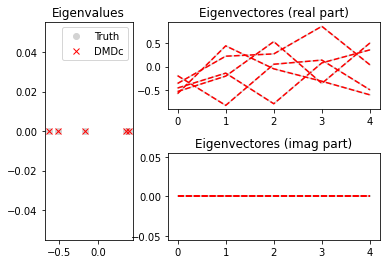

In [50]:
# Estimate inverse of measurement matrix C
r = n_states
Uc,sc,Vch = np.linalg.svd(C,full_matrices=False)
Sc = np.diag(sc[:r])
Cinv = np.dot(Vch[:,:r].T, np.dot(np.linalg.inv(Sc), Uc[:,:r].T))

# Output projection matrix of DMDc model
P = model.projection_matrix_output

# Estimate Atilde as approximation to A (for where x lives, not y)
Atilde = np.dot(Cinv,np.dot(np.dot(P,np.dot(Aest, P.T)),C))

# Spectral decomposition
Wtilde, Vtilde = np.linalg.eig(Atilde)


grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.5)

ax = plt.subplot(grid[0:, 0], title='Eigenvalues')
ax.plot(np.real(W), np.imag(W), 'o', color='lightgrey', label='Truth')
ax.plot(np.real(Wtilde), np.imag(West), 'xr', label='DMDc')
ax.legend()

ax = plt.subplot(grid[0, 1:], title='Eigenvectores (real part)')
for i in range(V.shape[1]):
    ax.plot(np.real(V[:,i]),'-', color='lightgrey', label='Truth')
for i in range(V.shape[1]):
    ax.plot(np.real(Vtilde[:,i]),'--', color='red', label='DMDc')

ax = plt.subplot(grid[1, 1:], title='Eigenvectores (imag part)')
for i in range(V.shape[1]):
    ax.plot(np.imag(V[:,i]),'-', color='lightgrey', label='Truth')
for i in range(V.shape[1]):
    ax.plot(np.imag(Vtilde[:,i]),'--', color='red', label='DMDc')

There may be a difference up to a sign in the eigenvectors.
Let's also plot the projection matrices.

[Text(0.5, 1.0, 'Proj Output')]

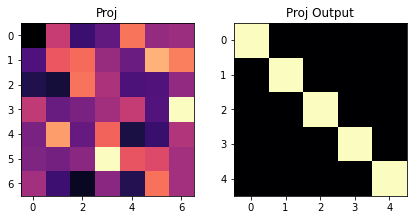

In [51]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(221)
ax.imshow(model.projection_matrix, aspect='equal', cmap=plt.get_cmap('magma'))
ax.set(title='Proj')

ax = fig.add_subplot(222)
ax.imshow(model.projection_matrix_output, aspect='equal', cmap=plt.get_cmap('magma'))
ax.set(title='Proj Output')